Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [669]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.crawler.fifa import extract_attributes


New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [670]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_prospect = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT MAX(Potential) as max_potential, * FROM fifa  GROUP BY ID )
GROUP BY ID
order by max_potential DESC
"""


In [671]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_prospect = pd.read_sql_query(sql_prospect, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_prospect = df_prospect.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])
df_raw = df_prospect.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID']).set_index(['ID','Name','FIFA'])


df_raw.head()

,,,potential_age,max_potential,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,prime_age,PrimeOverall
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2014,26.0,97.0,26.0,https://cdn.sofifa.net/players/158/023/14_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,94.0,97.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€78M,€450K,2173.0,CF,10273.0,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,90.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,24.0,94.0
231747,K. Mbappé,2020,20.0,95.0,20.0,https://cdn.sofifa.net/players/231/747/20_60.png,France,https://cdn.sofifa.net/flags/fr.png,89.0,95.0,Paris Saint Germain,https://cdn.sofifa.net/meta/team/591/30.png,€93.5M,€150K,2133.0,"ST,RW",12588.0,78.0,89.0,77.0,82.0,79.0,91.0,79.0,63.0,70.0,90.0,96.0,96.0,92.0,89.0,83.0,83.0,76.0,84.0,76.0,79.0,62.0,38.0,89.0,80.0,70.0,NaN,34.0,32.0,13.0,5.0,7.0,11.0,6.0,84.0,34.0,22.0,91.0
190871,Neymar,2017,24.0,95.0,24.0,https://cdn.sofifa.net/players/190/871/17_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,92.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€109M,€450K,2077.0,LW,17441.0,75.0,89.0,62.0,81.0,83.0,96.0,78.0,79.0,75.0,95.0,93.0,90.0,96.0,88.0,82.0,78.0,61.0,70.0,49.0,77.0,56.0,36.0,90.0,80.0,81.0,21.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,80.0,NaN,24.0,92.0
20801,Cristiano Ronaldo,2014,28.0,95.0,28.0,https://cdn.sofifa.net/players/020/801/14_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,92.0,95.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€56M,€325K,2220.0,"LW,LM",10272.0,83.0,92.0,86.0,82.0,85.0,90.0,88.0,79.0,72.0,95.0,91.0,94.0,93.0,90.0,75.0,94.0,94.0,89.0,79.0,93.0,63.0,24.0,89.0,81.0,85.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,31.0,94.0
239085,E. Haaland,2023,21.0,94.0,21.0,https://cdn.sofifa.net/players/239/085/23_60.png,Norway,https://cdn.sofifa.net/flags/no.png,88.0,94.0,Manchester City,https://cdn.sofifa.net/meta/team/9/30.png,€148M,€220K,2120.0,ST,12459.0,47.0,94.0,79.0,74.0,88.0,78.0,77.0,62.0,53.0,82.0,82.0,94.0,76.0,88.0,72.0,94.0,74.0,81.0,93.0,87.0,85.0,43.0,89.0,74.0,76.0,NaN,53.0,29.0,7.0,14.0,13.0,11.0,7.0,85.0,44.0,22.0,91.0


In [672]:
best_pos = lambda x: x.split(',')[0]

# Apply the lambda function to add best position
df_raw["best_position"] = df_raw['Position'].apply(best_pos)
df_raw["best_position"].value_counts()

best_position
CB     9791
ST     8957
CM     6622
GK     6586
CDM    4442
RB     4028
LB     3993
CAM    3858
RM     3106
LM     2995
RW     1503
LW     1342
CF      838
RWB     398
LWB     382
RF       72
LF       66
SW        8
Name: count, dtype: int64

In [673]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<83)&(df.Age<26)&(df.Potential>83)]

In [674]:

df = df[df.prime_age>df.potential_age]
df = df[(df.Potential>83)]
df['target'] = ~((df.max_potential>83)&(df.PrimeOverall<83))
df = df[df.potential_age<26]
df.target.value_counts()


df_processed = df.copy()

In [675]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set
ID,Name,FIFA,,,,,,,,,
231747,K. Mbappé,2020,20.0,20.0,22.0,95.0,95.0,89.0,91.0,True,test
239085,E. Haaland,2023,21.0,21.0,22.0,94.0,94.0,88.0,91.0,True,valid
230621,G. Donnarumma,2018,18.0,18.0,22.0,94.0,94.0,82.0,89.0,True,train
242444,João Félix,2020,19.0,19.0,22.0,93.0,93.0,80.0,84.0,True,test
200389,J. Oblak,2018,24.0,24.0,26.0,93.0,93.0,88.0,91.0,True,train


In [676]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [677]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head()

Marking          0.04
Balance          0.04
GKPositioning    0.04
Acceleration     0.04
GKHandling       0.05
Name: target, dtype: float64

In [678]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
df[df.target].describe().round(3).compare(df[~df.target].describe().round(3))



potential_age          max_potential               Age           \
               self    other          self    other     self    other   
count       207.000  736.000       207.000  736.000  207.000  736.000   
mean         22.691   20.461        87.643   85.279   22.691   20.461   
std           1.872    2.096         2.331    1.373    1.872    2.096   
min          18.000   16.000           NaN      NaN   18.000   16.000   
25%          22.000   19.000        86.000   84.000   22.000   19.000   
50%          23.000   20.000        87.000   85.000   23.000   20.000   
75%          24.000   22.000        89.000   86.000   24.000   22.000   
max             NaN      NaN        95.000   90.000      NaN      NaN   

       Overall          Potential            Special           Unnamed: 0  \
          self    other      self    other      self     other       self   
count  207.000  736.000   207.000  736.000   207.000   736.000    207.000   
mean    81.217   73.110    87.643   85.279  1942.556  1778.749  12265.343   
std      3.338    4.642     2.331    1.373   233.762   213.549   2426.579   
min     69.000   59.000       NaN      NaN  1158.000   903.000   8437.000   
25%     80.000   70.000    86.000   84.000  1890.500  1671.750  10587.500   
50%     81.000   74.000    87.000   85.000  1982.000  1805.000  11312.000   
75%     83.000   77.000    89.000   86.000  2085.500  1923.500  12740.000   
max     89.000   81.000    95.000   90.000  2295.000  2193.000  17433.000   

                 Crossing          Finishing          HeadingAccuracy  \
           other     self    other      self    other            self   
count    736.000  207.000  736.000   207.000  736.000         207.000   
mean   10480.285   64.643   58.376    61.010   56.163          62.188   
std     2491.137   19.018   16.638    21.751   18.774          19.125   
min     2018.000    9.000    5.000     9.000    3.000             NaN   
25%     9185.000   59.500   51.000    49.500   45.000          52.000   
50%    10562.000   70.000   63.000    68.000   62.000          67.000   
75%    11986.250   77.000   70.000    77.000   70.000          76.000   
max    17148.000   91.000   88.000    94.000   87.000          92.000   

               ShortPassing           Volleys          Dribbling           \
         other         self    other     self    other      self    other   
count  736.000      207.000  736.000  207.000  736.000   207.000  736.000   
mean    57.010       74.618   68.022   59.367   52.440    72.391   67.711   
std     15.922       14.340   12.048   20.577   16.883    20.150   17.231   
min        NaN       14.000   11.000    8.000    4.000     9.000    7.000   
25%     48.000       74.000   64.000   47.000   42.000    70.000   65.000   
50%     59.000       78.000   70.000   66.000   56.000    79.000   73.000   
75%     69.000       83.000   76.000   75.500   65.000    85.000   78.000   
max     86.000       93.000   88.000   91.000   84.000    92.000   91.000   

         Curve          FKAccuracy          LongPassing          BallControl  \
          self    other       self    other        self    other        self   
count  207.000  736.000    207.000  736.000     207.000  736.000     207.000   
mean    64.560   56.995     57.155   49.774      68.599   60.732      75.652   
std     20.487   17.328     19.858   16.981      14.880   13.653      16.884   
min      7.000    5.000      8.000    4.000      12.000   11.000      11.000   
25%     57.500   48.000     45.500   38.000      63.500   53.000      76.000   
50%     72.000   61.500     62.000   51.000      73.000   64.000      81.000   
75%     79.000   69.000     73.000   62.000      78.000   71.000      84.000   
max     87.000   89.000     90.000   91.000      92.000   85.000      91.000   

               Acceleration          SprintSpeed           Agility           \
         other         self    other        self    other     self    other   
count  736.000      207.000  736.000     20

###  Feature Engineering

In [679]:
PLAYER_ATTRIBUTES = [ 'Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
# PLAYER_ATTRIBUTES = [ 'Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
#                       'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
#                       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
#                       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
# PLAYER_ATTRIBUTES = [ 'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance',  'Jumping', 'Stamina', 'Strength',  'Aggression', 'Positioning', 'Vision']

#### Transform Defense Attributs

In [680]:

if False:
    df['Defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
    df_potentials['Defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)
    PLAYER_ATTRIBUTES.append('Defense')


#### Transform Value

In [681]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [682]:
df['target'].value_counts()

target
False    736
True     207
Name: count, dtype: int64

In [683]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [684]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [685]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

In [686]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import shap 
import shap  # For SHAP values
import pickle

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    'Support Vector Classifier': SVC(class_weight=class_weights,probability=True,kernel='linear'),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }
    if False:
        try:
            # Interpret the model using SHAP values
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test_scaled_df)
            # Save SHAP values to a pickle file
            with open(f"{model_name}_shap_values.pkl", "wb") as file:
                pickle.dump(shap_values, file)
        except:
            print("Fehler bei SHAP",model_name)

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Logistic Regression training----->
Decision Tree Classifier training----->
Random Forest Classifier training----->
Support Vector Classifier training----->
XGBoost Classifier training----->
LightGBM Classifier training----->
[LightGBM] [Info] Number of positive: 106, number of negative: 280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 386, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.274611 -> initscore=-0.971351
[LightGBM] [Info] Start training from score -0.971351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

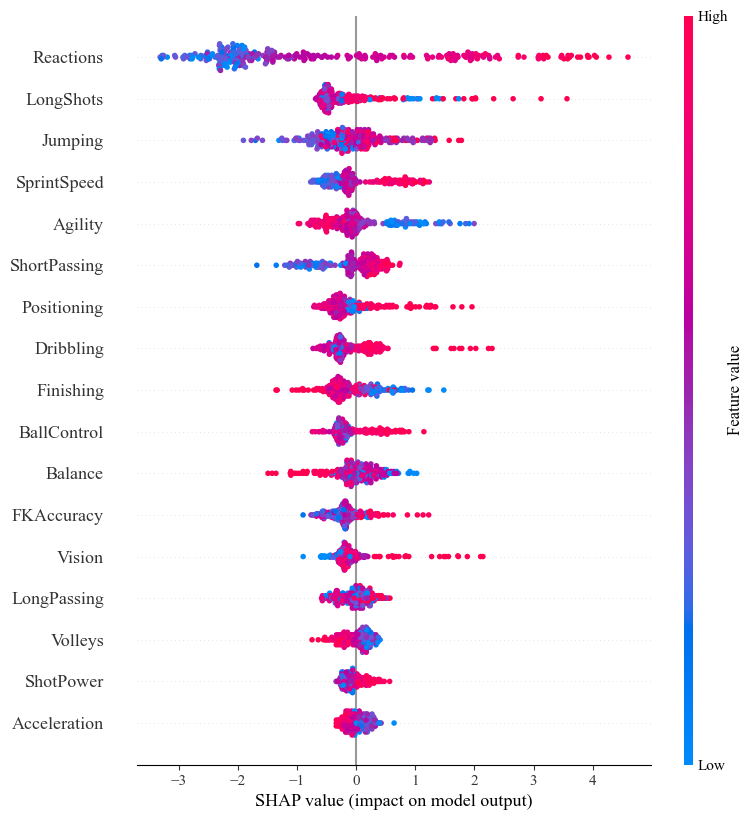

In [687]:
from src.sport_analytics.model.eval import individual_shap_valuess
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values[1], X_test_scaled_df)

In [688]:
explainer.expected_value[1]

-3.1629045580501765

In [689]:
player_skills.index.get_level_values('Name')

Index(['D. Szoboszlai'], dtype='object', name='Name')

In [690]:
X_test_scaled_df[~y_test].head(20)

,,,Finishing,ShortPassing,Volleys,Dribbling,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,LongShots,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,,
253004,Ansu Fati,2021,0.881731,0.178399,0.219845,0.532579,-0.406539,0.441653,0.337453,1.106545,1.036935,1.167823,-0.326209,0.940973,0.044847,0.479564,0.551276,0.348447,0.168276
243812,Rodrygo,2021,1.032106,0.250961,0.651154,0.790516,1.111208,-0.375008,0.519886,1.025834,0.951900,1.015224,0.720916,1.156021,0.298484,0.479564,0.603934,1.092641,0.439767
246147,M. Greenwood,2021,1.082231,0.250961,0.489413,0.532579,0.677566,0.441653,0.337453,0.299428,0.611763,0.252225,0.459134,0.224147,0.995988,-0.415993,1.077860,0.794963,0.643386
245371,T. Almada,2021,0.781481,0.105836,0.758981,0.532579,0.785976,0.305543,0.337453,1.025834,0.866866,1.320423,-1.766006,1.801164,0.552122,-1.132438,0.709251,0.398060,0.304022
236772,D. Szoboszlai,2020,0.480732,0.178399,0.758981,0.532579,1.328029,0.645818,0.519886,0.057293,0.696797,0.252225,-0.587990,0.152465,0.361894,0.390008,0.761910,0.050770,0.507640
236610,M. Kean,2020,0.981981,-0.764915,0.812894,0.429404,-0.514950,-1.668055,0.398264,0.380140,0.611763,0.023325,-0.064428,0.654243,0.361894,0.658675,0.024692,0.844576,-0.917691
236007,E. Barco,2019,0.480732,0.396086,-0.642773,0.738928,0.460745,-0.579173,0.155021,1.187257,0.356660,0.633724,-0.326209,1.227703,0.298484,-2.207106,0.077351,0.348447,0.575513
235569,T. Ndombele,2020,0.079732,1.049149,0.219845,0.996865,0.298129,1.122203,0.884752,0.702987,0.101557,0.710024,1.506259,1.227703,0.869169,-0.415993,0.287984,0.447673,1.254243
233927,Lucas Paquetá,2020,0.881731,0.613774,0.812894,0.790516,1.111208,0.918038,0.519886,-0.023419,0.186591,0.023325,0.982697,-0.062583,0.678941,1.196009,0.761910,0.993415,0.643386


In [731]:
sum(df.index.get_level_values("ID")==228702)

0

In [725]:
ID = 228702


X_scaled = scaler.transform(X[PLAYER_ATTRIBUTES].fillna(0))
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=PLAYER_ATTRIBUTES)

player_skills = np.round(X_scaled_df[X_scaled_df.index.get_level_values('ID')==ID],3)

pred = model.predict_proba(player_skills)[0][1]
print("pred",pred)
from src.sport_analytics.model.eval import get_shap_plot_indv


get_shap_plot_indv(skills = player_skills,explainer=explainer)
df.loc[player_skills.index.values[0]][PLAYER_ATTRIBUTES]

ValueError: Input data must be 2 dimensional and non empty.

In [700]:
from sklearn.metrics import precision_score
y_score = model.predict_proba(X_test_scaled_df)[:,1]>0.1
pre = np.round(precision_score(y_pred=y_score,y_true=y_test),3)
print("Potentials:",sum(y_score),"Precision:",pre,"------> Correct Potentials",pre*sum(y_score))
X_test[y_score]
shap_values = explainer.shap_values(X_test_scaled_df)
shaps = individual_shap_valuess(values = shap_values[1], attributes = PLAYER_ATTRIBUTES,player_index = X_test_scaled_df.index)

Potentials: 83 Precision: 0.458 ------> Correct Potentials 38.014


In [ ]:
shaps

In [701]:
shaps.mean().sort_values()

Reactions      -3.125000e-05
Balance        -2.430556e-05
FKAccuracy     -1.388889e-05
Vision         -3.472222e-06
SprintSpeed    -3.472222e-06
ShortPassing   -3.472222e-06
Dribbling      -3.450172e-17
Jumping        -3.315249e-17
Volleys         1.850372e-17
ShotPower       3.472222e-06
Finishing       3.472222e-06
Positioning     3.472222e-06
Acceleration    1.041667e-05
LongShots       1.388889e-05
BallControl     2.430556e-05
LongPassing     3.125000e-05
Agility         3.125000e-05
summe_shap      4.166667e-05
dtype: float64

In [702]:
%load_ext autoreload
%autoreload 2
from src.sport_analytics.model.eval import plot_feature_importance
if False:
    # Example usage:
    my_model = model_results['LightGBM Classifier']['Model']
    features = plot_feature_importance(my_model, 'LightGBM Classifier')

    my_model = model_results['Random Forest Classifier']['Model']
    features = plot_feature_importance(my_model, 'Random Forest Classifier')
    


    my_model = model_results['XGBoost Classifier']['Model']
    features = plot_feature_importance(my_model, 'XGBoost Classifier')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### evaluate test data

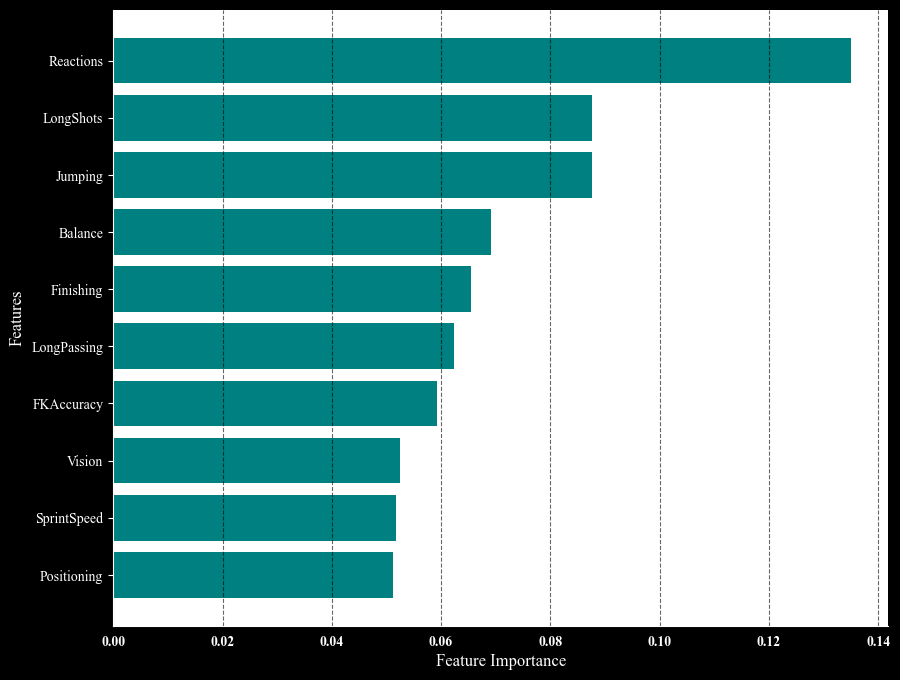

['Reactions',
 'LongShots',
 'Jumping',
 'Balance',
 'Finishing',
 'LongPassing',
 'FKAccuracy',
 'Vision',
 'SprintSpeed',
 'Positioning']

In [703]:
my_model = model_results['LightGBM Classifier']['Model']
features = plot_feature_importance(my_model, '')
features

In [704]:
import pickle

try:
    # Interpret the model using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    # Save SHAP values to a pickle file
    with open(f"{model_name}_shap_values.pkl", "wb") as file:
        pickle.dump(shap_values, file)
except:
    print("Fehler bei SHAP",model_name)

### predict potentials

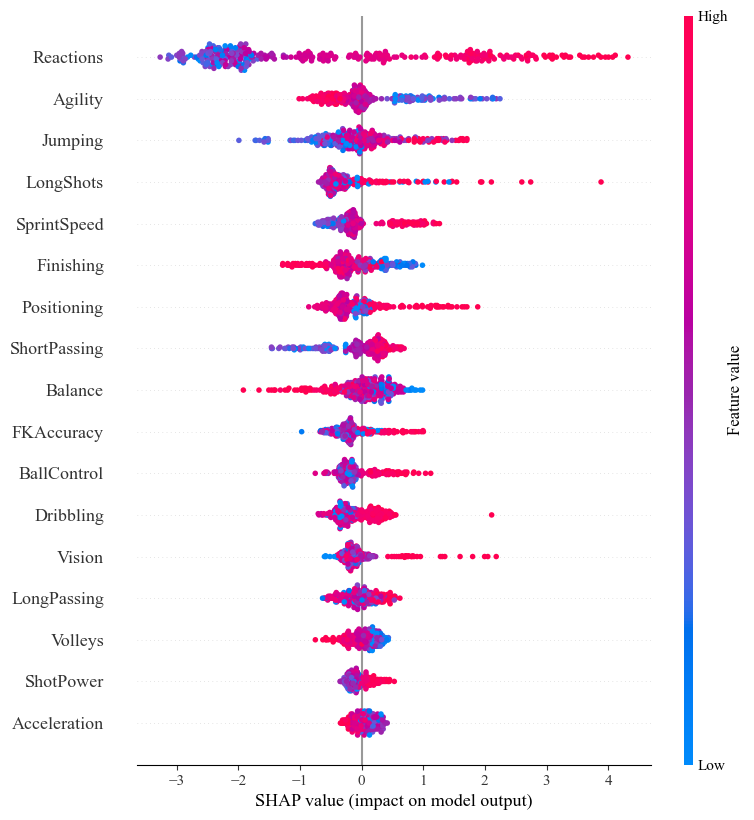

In [705]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df_potentials_scaled_df)
shap.summary_plot(shap_values[1], df_potentials_scaled_df)

In [706]:



shaps = individual_shalues(values = shap_values[1], attributes = PLAYER_ATTRIBUTES,player_index = df_potentials_scaled_df.index)



In [707]:
result = np.where(joined_df.corr()['prediction'].drop('prediction') > 0, 1, -1)

In [708]:
(result*abs(shaps).mean())

Finishing       0.369377
ShortPassing    0.344307
Volleys         0.181356
Dribbling       0.272364
FKAccuracy      0.286389
LongPassing     0.211764
BallControl     0.272790
Acceleration    0.146625
SprintSpeed     0.372452
Agility         0.474537
Reactions       1.865994
Balance         0.335033
ShotPower       0.147233
Jumping         0.470306
LongShots       0.444511
Positioning     0.349245
Vision          0.237092
summe_shap      3.480796
dtype: float64

In [709]:
prospects = pd.DataFrame(my_model.predict_proba(df_potentials_scaled_df)[:,1],columns=["prediction"],index=df_potentials.index)
joined_df = shaps.join(prospects)

In [710]:
joined_df.sort_values('prediction',ascending=False).to_excel('prospects.xlsx')

ModuleNotFoundError: No module named 'openpyxl'

In [ ]:
df

# TODO: SHAP VALUES FOR
# df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = True).head(5)

In [ ]:
prospects[prospects.prediction>0.5].sort_values()

In [ ]:
df_prospect.loc[240243][["potential_age","max_potential"	,"Age","FIFA","Overall"]]

In [ ]:
prospects.value_counts()

In [ ]:
prospects.sort_values('prediction',ascending=False).round(3).value_counts()